# ddm-RL Model Fitting

## Section 2: Model Fitting

In [1]:
import os, pystan
import numpy as np
import _pickle as cPickle
from pandas import DataFrame, read_csv
from scripts.diagnostics import check_div, check_energy, check_treedepth
%load_ext jupyternotify

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Define parameters.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Select model.
model_name = 'ddmRL_toy.stan'

## Sampling parameters.
samples = 500
warmup = 250
chains = 4
thin = 1
n_jobs = 4

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Load and prepare data.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Load and prepare behavior data.
data = read_csv('data/moodRL_data.csv')
data = data[data.Block < 4]
data = data.fillna(-1)

## Load and prepare ratings data.
ratings = read_csv('data/moodRL_ratings.csv')
ratings = ratings[ratings.Variable=='Mood']

## Load and prepare metadata.
metadata = read_csv('data/moodRL_metadata.csv')

## Define metadata.
N = data.Datetime.unique().size
B = data.Block.max()
T = data.Trial.max()

## Extract and prepare stimulus presentation data.
## Stimulus presentation is sorted such that the
## more valuable machine occupies the right column.
X = data[['M1','M2']].values.reshape(N,B,T,2)
X = np.sort(X, axis=-1) 

## Extract and prepare choice data. Choice data 
## recoded to range [1, 2], where 1 = less valuable, 
# 2 = more valuable. Missing values coded as -1.
Y = data.Choice.values.reshape(N,B,T,1)
Y = np.where( np.any(np.equal(X, Y), axis=-1), np.argmax(np.equal(X, Y), axis=-1) + 1, -1 )

## Extract and prepare RT data.
Z = data.RT.values.reshape(N,B,T)
Zmin = np.apply_over_axes(np.nanmin, np.where(Z < 0, np.nan, Z), [1,2]).squeeze()
if np.any(Zmin < 0.2): raise ValueError('WARNING: Min RTs too low!')
    
## Extract and prepare reward data. All rewards 
## scaled between [0,1].
R = data.Outcome.values.reshape(N,B,T)
R = np.where(R > 0, 1, 0)

## Extract and prepare mood data.
M = ratings.loc[ratings.Trial>0, 'Rating'].values.reshape(N,B,3) / 4

h12 = ratings.loc[ratings.Trial==0, 'Rating'].values.reshape(N,2) / 4
h12 = np.where(h12==-1, -0.99, np.where(h12==1, 0.99, h12))
h12 = np.arctanh(h12)

## Extract and prepare WoF data.
WoF = np.sign(metadata.WoF.values) * 28

## TESTING
X = X[0]
Y = Y[0]
Z = Z[0]
R = R[0]
M = M[0]

## Organize data dictionary.
dd = dict(N=N, B=B, T=T, X=X, Y=Y, Z=Z, R=R, M=M, h12=h12, WoF=WoF)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Fit model with Stan.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

if model_name:

    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    ### Model fitting and diagnostics.
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
        
    ## Define control parameters.
    if 'orig' in model_name: control = dict(adapt_delta = 0.9)
    else: control = None
        
    ## Fit model.
    file = 'stan_models/%s' %model_name
    fit = pystan.stan(file=file, data=dd, iter=samples, warmup=warmup, thin=thin, 
                      chains=chains, control=control, n_jobs=n_jobs, seed=47404)
    check_div(fit); check_treedepth(fit); check_energy(fit)

    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    ### Save data.
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

    ## Create out-directory.
    out_dir = 'stan_fits/%s' %model_name.replace('.stan','')
    if not os.path.isdir(out_dir): os.makedirs(out_dir)

    ## Save summary file.
    summary = fit.summary()
    summary = DataFrame(summary['summary'], columns=summary['summary_colnames'], index=summary['summary_rownames'])
    summary.to_csv(os.path.join(out_dir, 'summary.csv'))

    ## Save contents of StanFit.
    extract = fit.extract()
    for k, v in dd.items(): extract[k] = v
    with open(os.path.join(out_dir, 'StanFit.pickle'), 'wb') as f: cPickle.dump(extract, f)
        
    print('Done.')

<IPython.core.display.Javascript object>

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_a79f7dfe1d491180dfab3d4ea6e56b9f NOW.
/home/szoro/Documents/software/anaconda3.6/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


0.0 of 1000 iterations ended with a divergence (0.0%)
0 of 1000 iterations saturated the maximum tree depth of 10 (0.0%)
E-BFMI indicated no pathological behavior
Done.


In [2]:
from scripts.wiener import wiener_rng

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Posterior predictive checks.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Extract samples.
extract = fit.extract()
alpha = extract['alpha']
tau = extract['tau']
drift = extract['drift']

## RNG.
Z_pred = np.zeros_like(drift)
Y_pred = np.zeros_like(drift)

n_samp, n_block, n_trial = Z_pred.shape
for i in np.arange(n_samp):
    for j in np.arange(n_block):
        for k in np.arange(n_trial):
            Z_pred[i,j,k], Y_pred[i,j,k] = wiener_rng(alpha[i], tau[i], 0.5, drift[i,j,k])
            
## Swap all 1s and 2s.
Y_pred = 3 - Y_pred

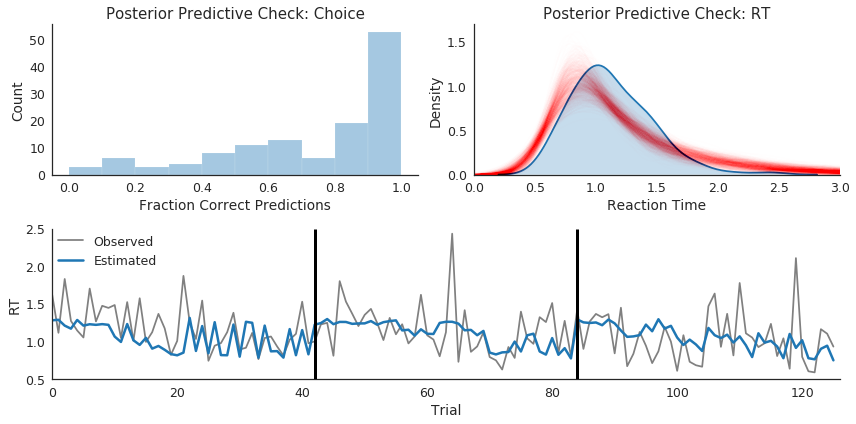

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')
sns.set_context('notebook', font_scale=1.25)
%matplotlib inline

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Plotting.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Initialize canvas.
fig = plt.figure(figsize=(12,6))

## Plot choice ppc. 
ax = plt.subplot2grid((2,2),(0,0))
Y_ppc = np.array([np.equal(Y,y) for y in Y_pred]).mean(axis=0)
sns.distplot(Y_ppc.flatten(), bins=np.arange(0,1.1,0.1), kde=False, 
             hist_kws=dict(edgecolor='w'), ax=ax)
ax.set(xlabel='Fraction Correct Predictions', ylabel='Count', title='Posterior Predictive Check: Choice')

## Plot RT ppc.
ax = plt.subplot2grid((2,2),(0,1))
sns.kdeplot(Z.flatten(), shade=True, ax=ax)
for arr in Z_pred: sns.kdeplot(arr.flatten(), color='r', alpha=0.005, ax=ax)
ax.set(xlabel='Reaction Time', xlim=(0,3), ylabel='Density', title='Posterior Predictive Check: RT')
    
## Plot RT timeseries.
ax = plt.subplot2grid((2,2),(1,0),colspan=2)
ax.plot(Z.flatten(), color='grey', label='Observed')
ax.plot(np.median(Z_pred, axis=0).flatten(), lw=2.5, label='Estimated')
ax.vlines([42,84], 0.5, 2.5, lw=3, color='k', zorder=90)
ax.set(xlim=(0,126), xlabel='Trial', ylim=(0.5,2.5), ylabel='RT')
ax.legend(loc=2, borderpad=0)
    
sns.despine()
plt.tight_layout()